In [1]:
import sys, os

env_root = '/N/project/baby_vision_curriculum/pythonenvs/hfenv/lib/python3.10/site-packages/'
sys.path.insert(0, env_root)

os.environ['OPENBLAS_NUM_THREADS'] = '38' #@@@@ to help with the num_workers issue
os.environ['OMP_NUM_THREADS'] = '1'  #10

import numpy as np
import torch, torchvision
from torchvision import transforms as tr
from tqdm import tqdm
from pathlib import Path
# import math
import argparse
import pandas as pd
import warnings

In [2]:

def _get_transform(image_size):

    mean = [0.5, 0.5, 0.5]#np.mean(mean_all, axis=0) #mean_all[chosen_subj] 
    std = [0.25, 0.25, 0.25] #std_all[chosen_subj] 
    
#     [0.485, 0.456, 0.406]  # IMAGENET_DEFAULT_MEAN
#     [0.229, 0.224, 0.225]  # IMAGENET_DEFAULT_STD

    augs = [tr.Resize(image_size), tr.CenterCrop(image_size), 
            tr.ConvertImageDtype(torch.float32), 
             tr.Normalize(mean,std)]
    return tr.Compose(augs)

def transform_vid(video):
    # Used with standard video datasets such as torchvision.UCF101
#     print(vid.shape)
    if video.shape[1]!=3: # Make it TCHW
        video = torch.permute(video, (0,3,1,2))
    image_size = 224
#     vid.p
    transform = _get_transform(image_size)
#     xtt = [transform(torch.from_numpy(frame)).unsqueeze(0) 
    xtt = [transform(frame).unsqueeze(0) 
       for frame in video]
    return torch.concat(xtt, axis=0)#.unsqueeze(0)

In [47]:
from torchvision.datasets.ucf101 import UCF101
class MyUCF101(UCF101):
    def __init__(self, root, annotation_path, frames_per_clip, step_between_clips=1, 
                 frame_rate= None, fold=1, train=True, transform=None, _precomputed_metadata=None, 
                 num_workers=1, _video_width=0, _video_height=0,
                 _video_min_dimension=0, _audio_samples=0, output_format='THWC'):
        super(MyUCF101, self).__init__(root, annotation_path, frames_per_clip, 
                                       step_between_clips=step_between_clips, 
                 frame_rate=frame_rate, fold=fold, train=train, transform=transform, 
                                       _precomputed_metadata=_precomputed_metadata, 
                 num_workers=num_workers, _video_width=_video_width, _video_height=_video_height,
                 _video_min_dimension=_video_min_dimension, _audio_samples=_audio_samples, 
                                       output_format=output_format)
        print('samples len:',len(self.samples))
        print('element type:',type(self.samples[0][0]))
        video_list = [x[0] for x in self.samples]
        
        self.indices = []
#         fold=1
        for train in [True, False]:
            fold=1
#             for fold in range(1,4):
            self.indices+=self._select_fold(video_list, annotation_path, fold, train)
#         self.indices = self.indices[::]
        video_clips = self.full_video_clips
        self.video_clips = video_clips.subset(self.indices)
        self.transform = transform

In [51]:
ucf_root='/N/project/baby_vision_curriculum/benchmarks/mainstream/ucf101/UCF-101'
annotation_path = '/N/project/baby_vision_curriculum/benchmarks/mainstream/ucf101/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist/'
frames_per_clip = 16
step_between_clips = 300#1
frame_rate=10#args.frame_rate#int(30/args.ds_rate)
transform = transform_vid
output_format= 'TCHW'
num_workers=6#args.num_workers-1 #40

dataset = MyUCF101(ucf_root, 
                  annotation_path,
                  frames_per_clip,
                  step_between_clips=step_between_clips,
                  frame_rate=frame_rate,
                  fold=1,
                  train=True,
                  transform=transform,
                  output_format=output_format,
                  num_workers=num_workers)

  0%|          | 0/833 [00:00<?, ?it/s]

samples len: 13320
element type: <class 'str'>


In [52]:
len(dataset)

13324

In [29]:
video, audio, label = dataset[0]

/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/torchvision/io/video.py:162: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


In [20]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


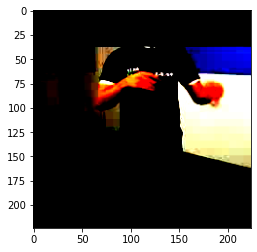

In [63]:
video, audio, label = dataset[13323]
xtt = video[0,:,:,:]
xtt_p = np.transpose(xtt, (1, 2, 0))
plt.imshow(xtt_p)

In [62]:
13324 /6

2220.6666666666665

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

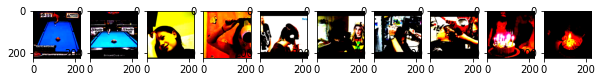

In [61]:
nplt = 10
fig,ax = plt.subplots(1,nplt, figsize=(10,2))
for i_sample in range(nplt):
    video, audio, label = dataset[10000+6*i_sample]
    xtt = video[0,:,:,:]
    xtt_p = np.transpose(xtt, (1, 2, 0))
    ax[i_sample].imshow(xtt_p)

In [6]:
# def __init__(
#         self,
#         root: str,
#         annotation_path: str,
#         frames_per_clip: int,
#         step_between_clips: int = 1,
#         frame_rate: Optional[int] = None,
#         fold: int = 1,
#         train: bool = True,
#         transform: Optional[Callable] = None,
#         _precomputed_metadata: Optional[Dict[str, Any]] = None,
#         num_workers: int = 1,
#         _video_width: int = 0,
#         _video_height: int = 0,
#         _video_min_dimension: int = 0,
#         _audio_samples: int = 0,
#         output_format: str = "THWC",
#     ) -> None:
#         super().__init__(root)
#         if not 1 <= fold <= 3:
#             raise ValueError(f"fold should be between 1 and 3, got {fold}")

#         extensions = ("avi",)
#         self.fold = fold
#         self.train = train

#         self.classes, class_to_idx = find_classes(self.root)
#         self.samples = make_dataset(self.root, class_to_idx, extensions, is_valid_file=None)
#         video_list = [x[0] for x in self.samples]
#         video_clips = VideoClips(
#             video_list,
#             frames_per_clip,
#             step_between_clips,
#             frame_rate,
#             _precomputed_metadata,
#             num_workers=num_workers,
#             _video_width=_video_width,
#             _video_height=_video_height,
#             _video_min_dimension=_video_min_dimension,
#             _audio_samples=_audio_samples,
#             output_format=output_format,
#         )
#         # we bookkeep the full version of video clips because we want to be able
#         # to return the metadata of full version rather than the subset version of
#         # video clips
#         self.full_video_clips = video_clips
#         self.indices = self._select_fold(video_list, annotation_path, fold, train)
#         self.video_clips = video_clips.subset(self.indices)
#         self.transform = transform

In [66]:
def ucf_collate(batch):
    filtered_batch = []
    for video, _, label in batch:
        filtered_batch.append((video, label))
    return torch.utils.data.dataloader.default_collate(filtered_batch)


In [68]:
sampler_shuffle = True #for the distributed dampler
#     num_epochs = args.n_epoch
batch_size = 64#args.batch_size# 128
pin_memory = False
num_workers = 6#args.num_workers #number_of_cpu-1#32
collate_fn = ucf_collate
dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, pin_memory=pin_memory, collate_fn=collate_fn,
        num_workers=num_workers, shuffle=False, drop_last=False)#sampler=sampler, 

In [69]:
for i_t, xbatch in enumerate(tqdm(dataloader)):
    inputs, fnames = xbatch
    
    if i_t==5:
        break

  2%|█                                          | 5/209 [00:12<08:23,  2.47s/it]


In [ ]:

dataset = torchvision.datasets.UCF101(ucf_root, 
                                          annotation_path,
                                          frames_per_clip,
                                          step_between_clips=step_between_clips,
                                          frame_rate=frame_rate,
                                          fold=1,
                                          train=True,
                                          transform=transform,
                                          output_format=output_format,
                                          num_workers=num_workers)